In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# from degree_days import dds
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction, contri, get_tensor, create_region_df_dfc_static
from create_matrix import *
from tensor_custom_core import *
from common import APPLIANCES_ORDER, contri

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [2]:
import sys
from degree_days import dds
case=2
a = 3
b = 2
source = 'Austin'
target = 'SanDiego'
constant_use = 'True'
start = 1
stop = 13

In [3]:
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)

# # using cosine similarity to compute L
source_L = get_L(source_static)
target_L = get_L(target_static)

# Seasonal constant constraints
if constant_use == 'True':
    T_constant = np.ones(stop-start).reshape(-1 , 1)
else:
    T_constant = None

In [4]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [119]:
agg_target = get_tensor_appliance(target_df, target_dfc, 'aggregate')
agg_source = get_tensor_appliance(source_df, source_dfc, 'aggregate')
tensor = np.concatenate((agg_source, agg_target), axis=0)

In [165]:
len(pd.DataFrame(agg_source[:, 0, :]).dropna())

262

In [120]:
static = np.r_[source_static, target_static]
L = get_L(static)
tensor_copy = tensor.copy()


In [121]:
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

945.777221456
336.103382167
176.219244051
155.290668066
150.585128989
149.041738519


In [122]:
from sklearn.cluster import KMeans
X = H.copy()
X = X/np.max(X)
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(X[:, :12])
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
y_pred

array([3, 0, 3, 0, 3, 0, 2, 1, 3, 1, 0, 3, 0, 3, 3, 3, 1, 0, 2, 3, 2, 3, 1,
       3, 0, 0, 1, 0, 3, 3, 3, 1, 3, 0, 0, 3, 3, 0, 1, 0, 1, 3, 3, 0, 0, 3,
       1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 2, 1, 3, 3, 3, 1, 3, 3, 2, 1, 0, 1,
       0, 0, 3, 1, 1, 3, 1, 1, 1, 0, 3, 3, 4, 0, 3, 3, 3, 0, 0, 1, 1, 0, 1,
       2, 2, 2, 0, 0, 2, 0, 1, 3, 1, 0, 3, 3, 0, 1, 0, 1, 2, 1, 0, 3, 0, 0,
       0, 0, 0, 3, 3, 0, 2, 3, 0, 1, 3, 0, 1, 3, 1, 1, 3, 0, 3, 1, 0, 3, 2,
       3, 1, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, 1, 1, 0, 3, 1, 3, 1, 0, 3, 3,
       1, 0, 1, 1, 3, 0, 1, 3, 1, 2, 2, 1, 3, 1, 1, 3, 3, 3, 3, 0, 2, 1, 3,
       1, 1, 3, 1, 3, 2, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 0, 2, 2, 1, 0, 1, 1,
       0, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 4, 2, 3, 0, 1, 3, 3, 1, 3, 3, 0, 2,
       0, 1, 0, 3, 0, 3, 1, 2, 3, 0, 1, 0, 3, 0, 0, 3, 1, 3, 0, 3, 0, 0, 2,
       1, 1, 0, 1, 3, 3, 0, 1, 1, 3, 0, 1, 3, 3, 0, 2, 3, 0, 2, 0, 1, 3, 2,
       1, 1, 3, 3, 0, 3, 1, 3, 3, 1, 3, 4, 1, 0, 1, 1, 3, 3, 1, 3, 1, 0, 2,
       3, 1,

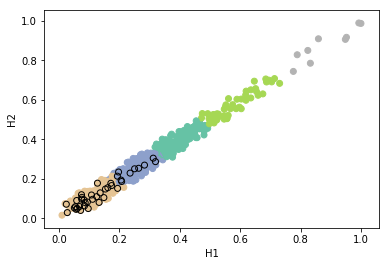

In [154]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

start = len(source_tensor)
# for x1 in range(3):
#     for x2 in range(3):
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
#     ax.scatter(X[:, x1], X[:, x2], c = y_label, cmap='autumn')
ax.scatter(X[:, x1], X[:, x2], c = y_pred, cmap='Set2')
ax.scatter(X[start:, x1], X[start:, x2], color='black', marker='o', facecolors='none')
# for i in range(start, len(X)):
#     ax.annotate(int(y_pred), (X[i, x1],X[i, x2]))
plt.xlabel("H1")
plt.ylabel("H2")
plt.savefig("Home_Factors_Agg.pdf", format='pdf')

In [39]:
from sets import Set
target_cluster = Set(y_pred[start:])
target_cluster

Set([1, 3])

In [49]:
source_index = [i for i, j in enumerate(y_pred[:start]) if j in target_cluster]

In [51]:
source_sub_tensor = source_tensor[source_index]

In [58]:
tensor_copy = source_tensor.copy()
H_all, A_all, T_all, Hs_all, As_all, Ts_all, HATs_all, costs_all = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.484093333
196.872283726
121.673570438
111.52870363
105.432654643
101.100135763


In [56]:
source_sub_static = source_static[source_index]
source_sub_L = get_L(source_sub_static)

In [67]:
tensor_copy = source_sub_tensor.copy()

H_sub, A_sub, T_sub, Hs_sub, As_sub, Ts_sub, HATs_sub, costs_sub = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_sub_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

326.353471124
90.0501131959
78.5128266125
76.2852952999
74.4635399643
73.5185982073


In [115]:
len(H_all)

533

In [73]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 3
b = 2
cost = 'abs'
start = 1
stop = 13


pred_all = {}
pred_sub = {}

for random_seed in range(5):
    
    pred_all[random_seed] = {}
    pred_sub[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_all[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_sub[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}



kf = KFold(n_splits=n_splits)

for random_seed in range(5):
    print "random seed: ", random_seed
    for train_percentage in range(10, 100, 20):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(target_df):
                print "round: ", rd


                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = target_df.index[train]
                test_ix = target_df.index[test]
                print "test_ix: ", test_ix

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = target_df.ix[train_test_ix], target_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, start, stop)
                print tensor.shape
                L_inner = target_L[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]


                ############################################################################################
                # Transfer learning: with A_all learned with all Austin Data
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L_inner,
                                                          a,
                                                          b,
                                                          num_iter=2000,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          A_known = A_all,
                                                          T_known=T_constant)
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_all[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                #############################################################################################
                # transfer learning: with A_sub learned with subset of Austin Data
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L_inner,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          A_known = A_sub,
                                                          T_known=T_constant)
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_sub[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))



                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
(7, 7, 12)
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
(7, 7, 12)
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
(7, 7, 12)
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
(7, 7, 12)
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
(7, 7, 12)
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
(7, 7, 12)
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
(7, 7, 12)
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
(7, 7, 12)
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
(7, 7, 12)
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
(6, 7, 12)
training percentage:  30
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
(14, 7, 12)
round:  1
test_ix:  Int64Index([15

round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
(35, 7, 12)
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
(35, 7, 12)
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
(35, 7, 12)
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
(35, 7, 12)
random seed:  2
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
(7, 7, 12)
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
(7, 7, 12)
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
(7, 7, 12)
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
(7, 7, 12)
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
(7, 7, 12)
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
(7, 7, 12)
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
(7, 7, 12)
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 85

round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
(35, 7, 12)
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
(35, 7, 12)
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
(35, 7, 12)
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
(35, 7, 12)
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
(35, 7, 12)
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
(35, 7, 12)
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
(35, 7, 12)
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
(35, 7, 12)
random seed:  4
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
(7, 7, 12)
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
(7, 7, 12)
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
(7, 7, 12)
round:  3
test_ix:  Int64Index([4083, 4095, 4329

In [128]:
out_all = {}
out_sub = {}
for random_seed in range(5):
    out_all[random_seed] = {}
    out_sub[random_seed] = {} 
    for appliance in APPLIANCES_ORDER[1:]:
        out_all[random_seed][appliance] = {}
        out_sub[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_all[random_seed][appliance][f]).ix[target_df.index]
            if appliance=="hvac":
                out_all[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_all[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

            s = pd.concat(pred_sub[random_seed][appliance][f]).ix[target_df.index]
            if appliance=="hvac":
                out_sub[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_sub[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [129]:
mean_out_all = pd.Panel(out_all).mean(axis=0)
mean_out_sub = pd.Panel(out_sub).mean(axis=0)


# mean_out_all = mean_out_all.rename(columns={'dw':'dw_all', 'fridge':'fridge_all', 'hvac':'hvac_all',
#                                              'mw':'mw_all', 'oven':"oven_all", 'wm':'wm_all'})
# mean_out_sub = mean_out_sub.rename(columns={'dw':'dw_sub', 'fridge':'fridge_sub', 'hvac':'hvac_sub',
#                                              'mw':'mw_sub', 'oven':"oven_sub", 'wm':'wm_sub'})
# mean_out_transfer_const_reg = mean_out_transfer_const_reg.rename(columns={'dw':'dw_transfer_const_reg_0.1', 'fridge':'fridge_transfer_const_reg_0.1', 'hvac':'hvac_transfer_const_reg_0.1',
#                                              'mw':'mw_transfer_const_reg_0.1', 'oven':"oven_transfer_const_reg_0.1", 'wm':'wm_transfer_const_reg_0.1'})
# mean_out_transfer_const_reg_1 = mean_out_transfer_const_reg_1.rename(columns={'dw':'dw_transfer_const_reg_1', 'fridge':'fridge_transfer_const_reg_1', 'hvac':'hvac_transfer_const_reg_1',
#                                              'mw':'mw_transfer_const_reg_1', 'oven':"oven_transfer_const_reg_1", 'wm':'wm_transfer_const_reg_1'})
# mean_out_transfer_const_reg_10 = mean_out_transfer_const_reg_10.rename(columns={'dw':'dw_transfer_const_reg_10', 'fridge':'fridge_transfer_const_reg_10', 'hvac':'hvac_transfer_const_reg_10',
#                                              'mw':'mw_transfer_const_reg_10', 'oven':"oven_transfer_const_reg_10", 'wm':'wm_transfer_const_reg_10'})

all_out = pd.concat([mean_out_all, mean_out_sub], axis=1)


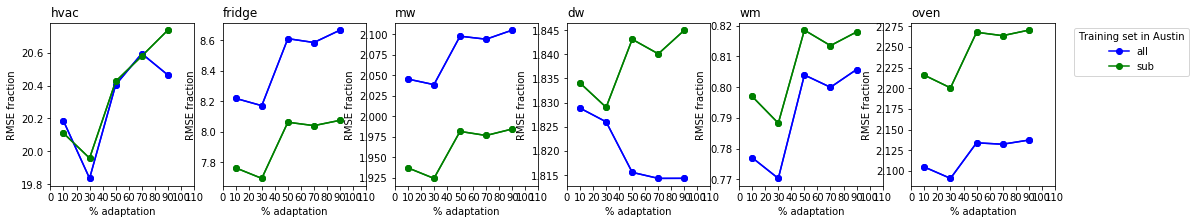

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(3,18))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance]
    df2 = all_out[appliance]
    


    df = pd.concat([df1, df2], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],  figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g'])
    legend = ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))
    legend.remove()

#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% adaptation");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
#     ax
    count += 1
plt.legend(['all', 'sub'], loc='best', bbox_to_anchor=(1.1, 1), title='Training set in Austin')
plt.savefig("appliance_comparison.pdf", format='pdf')

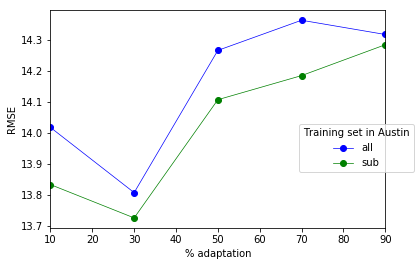

In [184]:
fig, ax = plt.subplots()
error = (pd.DataFrame(mean_out_all)*pd.Series(contri['SanDiego'])).sum(axis=1)
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
# error.plot(marker='.',ax=ax, legend=False, linewidth=0.6)

error = (pd.DataFrame(mean_out_sub)*pd.Series(contri['SanDiego'])).sum(axis=1)
error.plot(label='sub',marker='o', ax=ax, linewidth=0.7, color=['g'])
# error.plot(marker='.',ax=ax, legend=False, linewidth=0.6)

plt.ylabel("RMSE")
plt.xlabel("% adaptation")
plt.legend(['all', 'sub'], loc='best', bbox_to_anchor=(1.1, 0.5), title='Training set in Austin')
plt.savefig("overall_comparison.pdf", format='pdf')

ValueError: If using all scalar values, you must pass an index

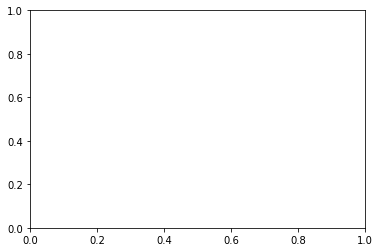

In [85]:
fig, ax = plt.subplots()

error = (pd.DataFrame(out_all)*pd.Series(contri['SanDiego'])).sum(axis=1)
#                 error = (pd.DataFrame(out[case][constant][static][transfer]).T).sum(axis=1)
error.plot(label=algo, marker='o', ax=ax, linewidth=0.7)
error.plot(label=algo, marker='.',ax=axins, legend=False, linewidth=0.6)